# **Importing data & pre-processing**
Import data from GitHub & set row names (same as in part1):

In [ ]:
# import file with NOT normalized expression data
dat.abundances <- read.table("https://raw.githubusercontent.com/ddz-icb/OmicsDataAnalysisCourse/main/data/dat.abundances.txt",
                            header=T,
                            sep="\t")
rownames(dat.abundances) <- dat.abundances[,1]        # set rownames to IDs from first column
dat.abundances <- data.matrix(dat.abundances[,-1])    # delete first column and change "data frame" to numeric "data matrix"



# import file with normalized data and extended information
dat.ext <- read.table("https://raw.githubusercontent.com/ddz-icb/OmicsDataAnalysisCourse/main/data/dat.ext.txt",
                            header=T,
                            sep="\t")

Keep only phosphorylated peptides (same as in part1):

In [ ]:
# give row numbers with phosphopeptides
phospep.idx <- grep("Phospho", dat.ext$Modifications)   # grep() gives all row numbers containing the given pattern in column 'Modifications'

# keep only phospopeptides
dat.abundances <- dat.abundances[phospep.idx,]
#dat.nonorm <- dat.nonorm[phospep.idx,]
dat.ext <- dat.ext[phospep.idx,]

In part1, we have determined that the normalization results of the device software are OK and that we can use them. Therefore, we do not need to perform our own raw data normalization. However, we want to perform a group-specific imputation and replace isolated missing values to avoid excluding almost completely quantified phosphopeptides in some analysis steps. For this, the same imputation as in part1 is performed.

In [ ]:
# Give row vectors with group-specific column numbers
basal.idx <- grep("Basal", colnames(dat.abundances))
insulin.idx <- grep("Insulin", colnames(dat.abundances))



dat.abundances2 <- dat.abundances
for(i in 1:nrow(dat.abundances2)){
    if(sum(is.na(dat.abundances2[i,basal.idx])) == 1){
      na.idx <- which(is.na(dat.abundances2[i,basal.idx]))
      dat.abundances2[i, basal.idx[na.idx]] <- mean(dat.abundances2[i, basal.idx], na.rm=T)
    }

    if(sum(is.na(dat.abundances2[i,insulin.idx])) == 1){
      na.idx <- which(is.na(dat.abundances2[i,insulin.idx]))
      dat.abundances2[i, insulin.idx[na.idx]] <- mean(dat.abundances2[i, insulin.idx], na.rm=T)
    }
}
nrow(dat.abundances)
nrow(na.omit(dat.abundances))   # na.omit() removes rows with at least on 'NA'
nrow(na.omit(dat.abundances2))

dat.abundances2 <- na.omit(dat.abundances2)   # delete phosphopeptides that still have missing values despite imputation

[1] 15210

[1] 9927

[1] 12044

# **Identification of differential candidates**
Calculate p-values and fold changes in order to identify differential candidates (same as in part2).

In [ ]:
phospep.number <- nrow(dat.abundances2)

# define empty vectors for storing...
fc <- vector(length=phospep.number, mode="numeric")
p.val <- vector(length=phospep.number, mode="numeric")
p.val.adj <- vector(length=phospep.number, mode="numeric")

# adopt IDs of vector elements from row IDs of dat.abundances2
names(fc) <- rownames(dat.abundances2)
names(p.val) <- rownames(dat.abundances2)
names(p.val.adj) <- rownames(dat.abundances2)



# Calculate fold changes
for(i in 1:phospep.number){
    basal.mean <- mean(dat.abundances2[i, basal.idx])
    insulin.mean <- mean(dat.abundances2[i, insulin.idx])

    fc[i] <- insulin.mean / basal.mean
}



# Calculate p-values and adjusted p-values
for(i in 1:phospep.number){
    p.val[i] <- t.test(log2(dat.abundances2[i, basal.idx]), log2(dat.abundances2[i, insulin.idx]))$p.value
}
p.val.adj <- p.adjust(p.val, method="fdr")



# Give row numbers of candidates with both large log-fold change and low adj. p-value
diff.idx1 <- which(abs(log2(fc)) > 1)         # trick: via absolute value of log2(fc) we get both phosphopeptides with fc > 2 or 1/2
diff.idx2 <- which(p.val.adj < 0.05)          # gives row indices of phosphopeptides with adj. p-value < 0.05
diff.idx <- intersect(diff.idx1, diff.idx2)   # intersection gives row indices of differential candidates
print(length(diff.idx))

# Give row numbers of candidates with more stringent thresholds
diff.idx1 <- which(abs(log2(fc)) > 1.25)
diff.idx2 <- which(p.val.adj < 0.005)
diff.idx <- intersect(diff.idx1, diff.idx2)
print(length(diff.idx))

[1] 961
[1] 345


# **Prepare the list of interesting candidates**
For overrepresentation analysis a list of proteins or genes is needed. Thus, first we have to map the phosphopeptide IDs (row IDs) of our candidates to protein IDs (UniProt IDs). These are the phosphopeptide IDs of our candidates:

In [ ]:
rownames(dat.abundances2)[diff.idx]

[1] "Q5HZI1_peptide1"            "Q91YM2_peptide2"           
  [3] "Q61409_peptide1"            "Q7TPS5_peptide1"           
  [5] "Q571K4_peptide1"            "Q9R0L6_peptide2"           
  [7] "Q8BGZ4_peptide1"            "Q8CCN5_peptide1"           
  [9] "Q9ESZ8-4_peptide1"          "P54103_peptide2"           
 [11] "P54103_peptide3"            "P54103_peptide4"           
 [13] "P70445_peptide2"            "Q6P5E6_peptide2"           
 [15] "Q91VE6_peptide1"            "Q3UZ39_peptide1"           
 [17] "P51125_peptide2"            "P51125-3_peptide1"         
 [19] "P61793_peptide1"            "Q8BTY2-2_peptide1"         
 [21] "Q60592_peptide2"            "P70445_peptide4"           
 [23] "P62754_peptide1"            "Q6NZF1_peptide2"           
 [25] "E9Q6J5_peptide1"            "Q9DBR7_peptide1"           
 [27] "Q501J7_peptide2"            "P55194_peptide1"           
 [29] "Q9Z2H5_peptide3"            "Q62511_peptide3"           
 [31] "Q91ZX6_peptide1"            "O70161_peptide1"           
 [33] "Q8K2X1_peptide1"            "Q8K3I9_peptide2"           
 [35] "Q61409_peptide6"            "Q8C052_peptide2"           
 [37] "Q80TJ7_peptide1"            "Q91X84_peptide1"           
 [39] "O54774_peptide5"            "Q62073_peptide2"           
 [41] "Q8K245_peptide2"            "Q6PA06_peptide3"           
 [43] "Q8BUH8_peptide1"            "Q6PA06_peptide4"           
 [45] "Q6P542_peptide2"            "Q8BJ05_peptide1"           
 [47] "Q8K310_peptide3"            "Q3TC46_peptide1"           
 [49] "Q61165_peptide1"            "Q6A065_peptide7"           
 [51] "Q501J7_peptide4"            "O70405_peptide2"           
 [53] "Q9QZQ1_peptide2"            "Q61990_peptide2"           
 [55] "Q8BGI4_peptide2"            "Q5SSH7_peptide2"           
 [57] "Q02780_peptide1"            "Q02780_peptide2"           
 [59] "Q8CJ19_peptide4"            "Q91WG5_peptide1"           
 [61] "Q91WG5_peptide2"            "Q80TS5_peptide1"           
 [63] "Q8CCN5_peptide2"            "Q63844_peptide1"           
 [65] "Q63844_peptide2"            "Q3UYV9_peptide6"           
 [67] "Q8C351_peptide2"            "Q3UMU9-2; Q3UMU9_peptide1" 
 [69] "Q9D4H9-2_peptide4"          "Q69ZX6_peptide1"           
 [71] "Q80YV2_peptide1"            "D3YZP9_peptide3"           
 [73] "Q8C180_peptide2"            "Q91WG5_peptide3"           
 [75] "Q5SVQ0_peptide3"            "Q6NZJ6_peptide1"           
 [77] "P49586_peptide4"            "O89110_peptide1"           
 [79] "Q9Z1M4_peptide2"            "Q9WTR6_peptide1"           
 [81] "Q3UHC7_peptide2"            "Q3UHJ0_peptide4"           
 [83] "A2A9C3_peptide2"            "O88746_peptide3"           
 [85] "Q6PD28_peptide1"            "Q9DBX1_peptide4"           
 [87] "Q8CGN5; Q8CGN5-3_peptide7"  "Q8CI08_peptide3"           
 [89] "P59672_peptide3"            "Q9JIH2_peptide1"           
 [91] "Q8BJU0_peptide1"            "P18654_peptide4"           
 [93] "Q9QWY8_peptide5"            "Q8BTI8_peptide20"          
 [95] "Q501J6_peptide1"            "Q9CQ20_peptide2"           
 [97] "P20152_peptide17"           "Q2TBE6_peptide1"           
 [99] "P63085_peptide2"            "Q9R1E0_peptide2"           
[101] "Q61286-2_peptide1"          "Q9CT10_peptide4"           
[103] "Q2NL51_peptide2"            "Q62433_peptide3"           
[105] "Q9JLN9_peptide6"            "P81122_peptide16"          
[107] "O35984_peptide1"            "Q925J9_peptide6"           
[109] "P35569_peptide8"            "P35569_peptide9"           
[111] "B2RS91_peptide1"            "Q8BGD9_peptide2"           
[113] "Q8BGD9_peptide3"            "P35569_peptide11"          
[115] "Q9QYF9_peptide3"            "Q8CJF7_peptide5"           
[117] "E9Q7G0_peptide7"            "Q571I4_peptide1"           
[119] "Q9JKB3; P62960_peptide1"    "Q8R4H2_peptide2"           
[121] "Q8K212_peptide2"            "A2A690_peptide2"           
[123] "Q8VDD9_peptide2"            "Q8VDD9_peptide3"           
[125] "Q3UMB5_peptide1"           

Since the UniProt ID is already part of the phosphopeptide IDs we just need to extract them via an R function that employs regular expressions. This function is gsub(), which can substitute or delete parts of a given string specified by a regular expression.

In [ ]:
uniprot.ids <- c()
for(i in 1:length(diff.idx)){
  #print(paste0("Original: ", rownames(dat.abundances2)[diff.idx[i]]))
  tmp <- gsub("_peptide\\d+", "", rownames(dat.abundances2)[diff.idx[i]])
  #print(paste0("After removing '_peptide\\d+': ", tmp))

  tmp <- gsub("-\\d+", "", tmp)
  #print(paste0("After removing '-\\d+': ", tmp))

  #tmp <- print(strsplit(tmp, "; "))
  tmp <- strsplit(tmp, "; ")
  #print("After splitting:")
  #print(tmp[[1]])
  uniprot.ids <- c(uniprot.ids, tmp[[1]])

  #print("-----------------------")
}
uniprot.ids <- unique(uniprot.ids)
print(uniprot.ids)
print(length(uniprot.ids))

write.table(x=uniprot.ids, file="uniprot.ids.txt", quote=F, sep="\t", row.names=F, col.names=F)

  [1] "Q5HZI1" "Q91YM2" "Q61409" "Q7TPS5" "Q571K4" "Q9R0L6" "Q8BGZ4" "Q8CCN5"
  [9] "Q9ESZ8" "P54103" "P70445" "Q6P5E6" "Q91VE6" "Q3UZ39" "P51125" "P61793"
 [17] "Q8BTY2" "Q60592" "P62754" "Q6NZF1" "E9Q6J5" "Q9DBR7" "Q501J7" "P55194"
 [25] "Q9Z2H5" "Q62511" "Q91ZX6" "O70161" "Q8K2X1" "Q8K3I9" "Q8C052" "Q80TJ7"
 [33] "Q91X84" "O54774" "Q62073" "Q8K245" "Q6PA06" "Q8BUH8" "Q6P542" "Q8BJ05"
 [41] "Q8K310" "Q3TC46" "Q61165" "Q6A065" "O70405" "Q9QZQ1" "Q61990" "Q8BGI4"
 [49] "Q5SSH7" "Q02780" "Q8CJ19" "Q91WG5" "Q80TS5" "Q63844" "Q3UYV9" "Q8C351"
 [57] "Q3UMU9" "Q9D4H9" "Q69ZX6" "Q80YV2" "D3YZP9" "Q8C180" "Q5SVQ0" "Q6NZJ6"
 [65] "P49586" "O89110" "Q9Z1M4" "Q9WTR6" "Q3UHC7" "Q3UHJ0" "A2A9C3" "O88746"
 [73] "Q6PD28" "Q9DBX1" "Q8CGN5" "Q8CI08" "P59672" "Q9JIH2" "Q8BJU0" "P18654"
 [81] "Q9QWY8" "Q8BTI8" "Q501J6" "Q9CQ20" "P20152" "Q2TBE6" "P63085" "Q9R1E0"
 [89] "Q61286" "Q9CT10" "Q2NL51" "Q62433" "Q9JLN9" "P81122" "O35984" "Q925J9"
 [97] "P35569" "B2RS91" "Q8BGD9" "Q9QYF9" "Q8CJF7" "E9Q7G0" "Q57

In [50]:
id.map <- read.table("https://raw.githubusercontent.com/ddz-icb/OmicsDataAnalysisCourse/main/data/idmapping_2023_11_21_to_GeneID.tsv",
                            header=T,
                            sep="\t")
head(id.map)

entrez.ids <- id.map[id.map$From %in% uniprot.ids,"To"]
print(entrez.ids)
length(entrez.ids)


,From,To
,<chr>,<int>
1,P31750,11651
2,Q91V92,104112
3,Q60823,11652
4,Q9Z120,17299
5,P62754,20104
6,Q3UPF5,78781


  [1] 104112  11652  20104  78781  18576  13685  72508  17356  22241  74105
 [11]  13688  16367  58988  16337  18016  13521 101706  75956  15193 384783
 [21] 110651  20238  20662  26413  67040  21968  68276 108099  18569  73473
 [31]  26417  13631 319481  67605 110157  17776  73158  56298  71175  17988
 [41] 230676  77038 224650 263406 229725  56449  22608  19303  26406  12380
 [51]  57752 232906 433702  58909  75705  56273 210789 338355  75725  27277
 [61]  16765  67772  71722 330662  18717  14886 109910 101490  12125  13821
 [71]  11797  70579 277854  71810 216873  14245  12615 227331  18572 229227
 [81]  22404  22225  17754 225929  71865 545389  20544  18521  56458  66315
 [91] 195018  52551 665775  15191  18027 194401  56717 102103 100169  66870
[101]  20401  75553 218850  80288 232679  67134  17342 108686 100226 231712
[111]  19708  71801  76559  18141 338366  67477  69601  68041 214290 269774
[121] 225896 106298  18647 320595  74522 244418  27967 114601 268903 327826
[131]  17347

[1] 260

# **GO-based overrepresentation analysis**
In order to perform Gene Ontology(GO)-based overrepresentation analysis ("GO-analysis" or "GO-ORA") various R packages can be used. E.g. the package "clusterProfiler" is popular and widely used. To use clusterProfiler in Google Colab we have to install it and the package "org.Mm.eg.db", which is a gene database for the species mus musculus (specific databases for all main species are available). Moreover, to visualize GO results we install also the packages "enrichplot" and "ggupset" providing useful plots for ORA results.

In [ ]:
# Warning: Installation of the packages takes ca. 19 minutes in Colab!
setRepositories(ind=1:5)
install.packages("clusterProfiler")
install.packages("org.Mm.eg.db")
install.packages("enrichplot")
install.packages("ggupset")
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
library(ggupset)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zlibbioc’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘formatR’, ‘XVector’, ‘GenomeInfoDb’, ‘lambda.r’, ‘futile.options’, ‘gridGraphics’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘lazyeval’, ‘plogr’, ‘png’, ‘Biostrings’, ‘futile.logger’, ‘snow’, ‘BH’, ‘cowplot’, ‘fastmatch’, ‘ggplotify’, ‘patchwork’, ‘ggforce’, ‘ape’, ‘tidytree’, ‘treeio’, ‘R.oo’, ‘R.methodsS3’, ‘BiocGenerics’, ‘Biobase’, ‘IRanges’, ‘RSQLite’, ‘S4Vectors’, ‘KEGGREST’, ‘BiocParallel’, ‘fgsea’, ‘reshape2’, ‘aplot’, ‘ggfun’, ‘ggnewscale’, ‘ggrepel’, ‘ggtangle’, ‘scatterpie’, ‘ggtree’, ‘R.utils’, ‘AnnotationDbi’, ‘DOSE’, ‘enrichplot’, ‘GO.db’, ‘GOSemSim’, ‘gson’, ‘igraph’, ‘plyr’, ‘qvalue’, ‘yulab.utils’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library

GO-ORA is performed via the enrichGO() function in clusterPlot. We have to specify the GO domain, i.e. "biological process" (BP), "cellular component" (CC) or "molecular function" (MF) via parameter "ont". Moreover we have to specify the apropriate speciec-specific gene database (via "OrgDb"), p-value cutoffs and a method for p-value adjustment. Via "as.data.frame()" the results can be inspected.

In [ ]:
ego <- enrichGO(gene = entrez.ids,
                #universe = as.character(id.map$To),
                OrgDb = org.Mm.eg.db,
                ont = "BP",
                pAdjustMethod = "fdr",
                pvalueCutoff = 0.01,
                qvalueCutoff = 0.05,
                readable = TRUE)
as.data.frame(ego)[1:15,]

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0032869,GO:0032869,cellular response to insulin stimulus,25/257,242/28928,0.10330579,11.628131,15.719055,2.047953e-19,6.866787e-16,4.846104e-16,Akt2/Pde3b/Eif4ebp1/Rps6kb1/Eif4ebp2/Irs1/Rps6kb2/Insr/Irs2/Sos1/Mapk1/Mapk3/Eef2k/Raf1/Tbc1d4/Lpin1/Slc9a1/Foxo1/Mtor/Sorbs1/Tns2/Gsk3a/C2cd5/Zfp36l1/Shc1,25
GO:0032868,GO:0032868,response to insulin,27/257,308/28928,0.08766234,9.867300,14.812514,5.060289e-19,8.483574e-16,5.987121e-16,Akt2/Rps6/Pde3b/Eif4ebp1/Rps6kb1/Eif4ebp2/Irs1/Rps6kb2/Insr/Irs2/Sos1/Mapk1/Mapk3/Eef2k/Raf1/Tbc1d4/Lpin1/Slc9a1/Foxo1/Mtor/Sorbs1/Tns2/Gsk3a/C2cd5/Zfp36l1/Shc1/Cd2ap,27
GO:0071375,GO:0071375,cellular response to peptide hormone stimulus,27/257,348/28928,0.07758621,8.733128,13.740753,1.151771e-17,1.287297e-14,9.084850e-15,Akt2/Pde3b/Eif4ebp1/Rps6kb1/Eif4ebp2/Irs1/Rps6kb2/Insr/Irs2/Sos1/Mapk1/Mapk3/Eef2k/Raf1/Pxn/Tbc1d4/Lpin1/Slc9a1/Foxo1/Mtor/Sorbs1/Tns2/Gsk3a/C2cd5/Zfp36l1/Shc1/Map3k7,27
GO:0008286,GO:0008286,insulin receptor signaling pathway,18/257,147/28928,0.12244898,13.782895,14.710648,1.277055e-15,1.070492e-12,7.554791e-13,Akt2/Eif4ebp1/Rps6kb1/Eif4ebp2/Irs1/Rps6kb2/Insr/Irs2/Sos1/Mapk1/Mapk3/Raf1/Foxo1/Sorbs1/Tns2/Gsk3a/C2cd5/Shc1,18
GO:0031929,GO:0031929,TOR signaling,17/257,184/28928,0.09239130,10.399594,12.109919,8.753281e-13,5.869950e-10,4.142605e-10,Rps6/Eif4ebp1/Rps6kb1/Eif4ebp2/Rps6kb2/Rps6ka3/Mapk3/Wdr59/Akt1s1/Larp1/Szt2/Depdc5/Mtor/Ccdc88a/Smcr8/Gsk3a/Sik3,17
GO:0006417,GO:0006417,regulation of translation,22/257,381/28928,0.05774278,6.499546,10.230713,5.147019e-12,2.876326e-09,2.029912e-09,Akt2/Eif4ebp1/Rps6kb1/Eif4ebp2/Rps6kb2/Mapk1/Mapk3/Eef2k/Larp1/Ybx1/Ncbp1/Gigyf2/Patl1/Mtor/Serbp1/Mknk2/Cnbp/Eif4g1/Zfp36l1/Gemin5/Abcf1/Map3k20,22
GO:0038202,GO:0038202,TORC1 signaling,12/257,116/28928,0.10344828,11.644170,10.875543,5.678917e-10,2.720201e-07,1.919730e-07,Rps6kb1/Rps6kb2/Rps6ka3/Mapk3/Wdr59/Akt1s1/Larp1/Szt2/Depdc5/Mtor/Smcr8/Sik3,12
GO:0048009,GO:0048009,insulin-like growth factor receptor signaling pathway,9/257,52/28928,0.17307692,19.481592,12.629012,7.902248e-10,3.312030e-07,2.337402e-07,Irs1/Atxn1/Sos1/Mapk1/Mapk3/Raf1/Gigyf2/Gigyf1/Shc1,9
GO:0006446,GO:0006446,regulation of translational initiation,10/257,74/28928,0.13513514,15.210853,11.588569,1.121424e-09,4.177926e-07,2.948492e-07,Akt2/Eif4ebp1/Rps6kb1/Eif4ebp2/Rps6kb2/Larp1/Ncbp1/Gigyf2/Mtor/Eif4g1,10


GO-ORA results visualization with bar plot...

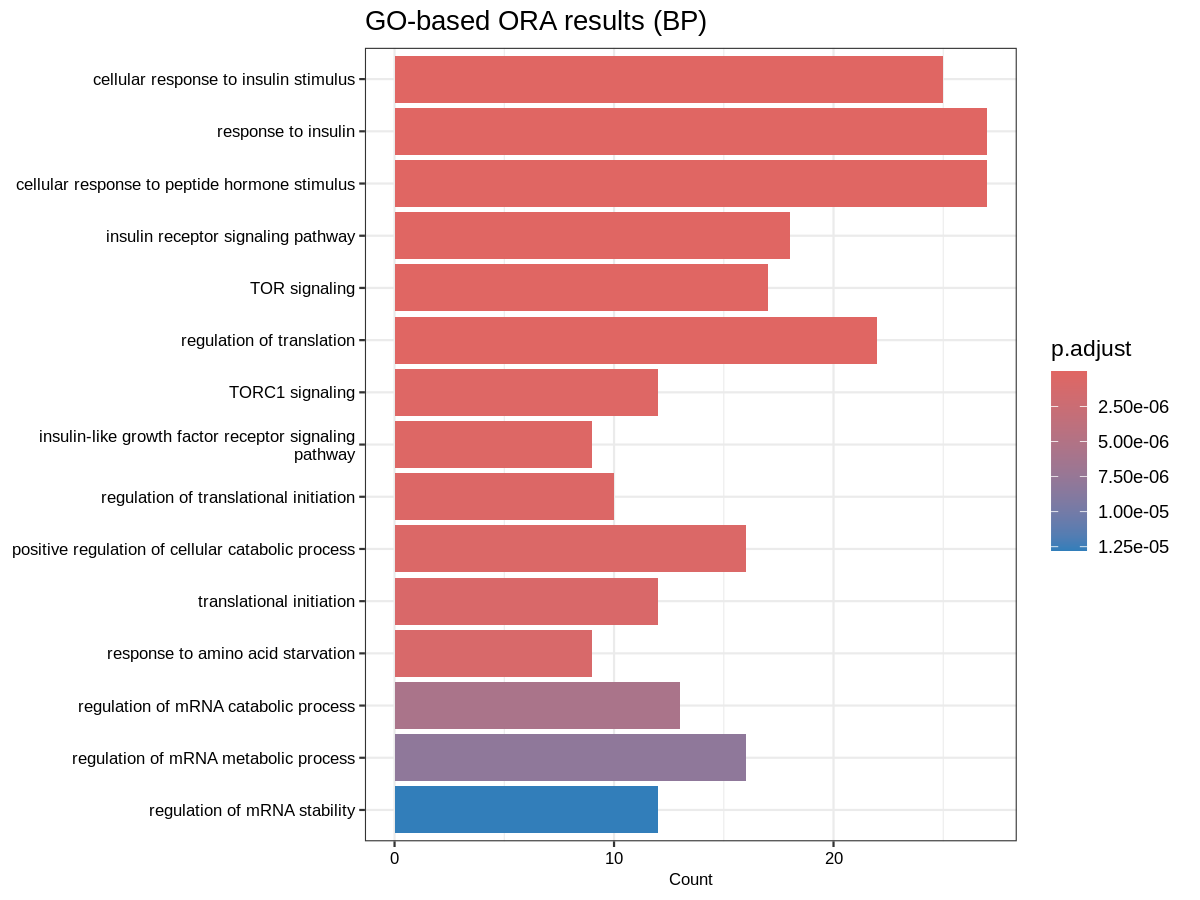

In [66]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res=150)
barplot(height=ego,
        color="p.adjust",
        showCategory=15,
        font.size=8,
        title="GO-based ORA results (BP)",
        label_format=50)

GO-ORA results visualization with dot plot...

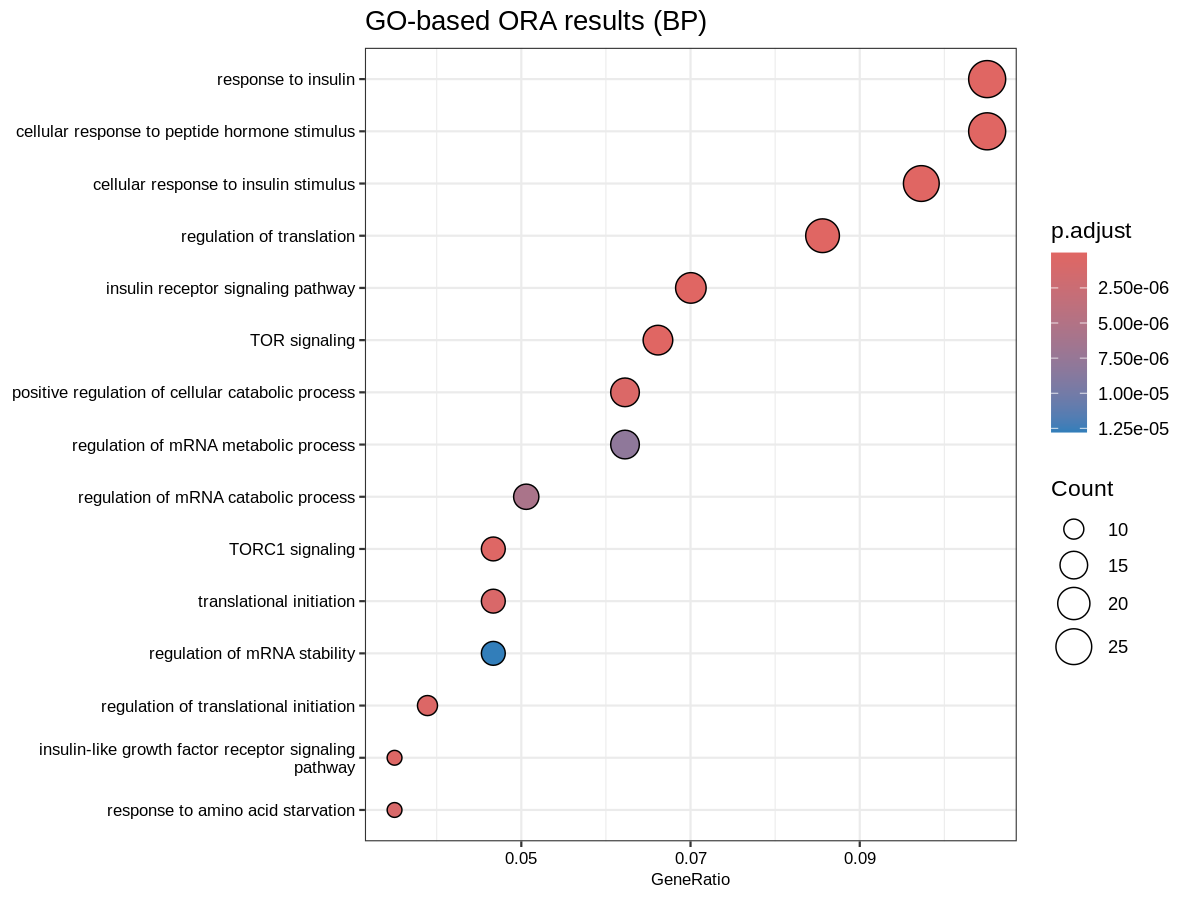

In [65]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res=150)
dotplot(object=ego,
        showCategory=15,
        font.size=8,
        title="GO-based ORA results (BP)",
        label_format=50)

GO-ORA results visualization with cnet plot...

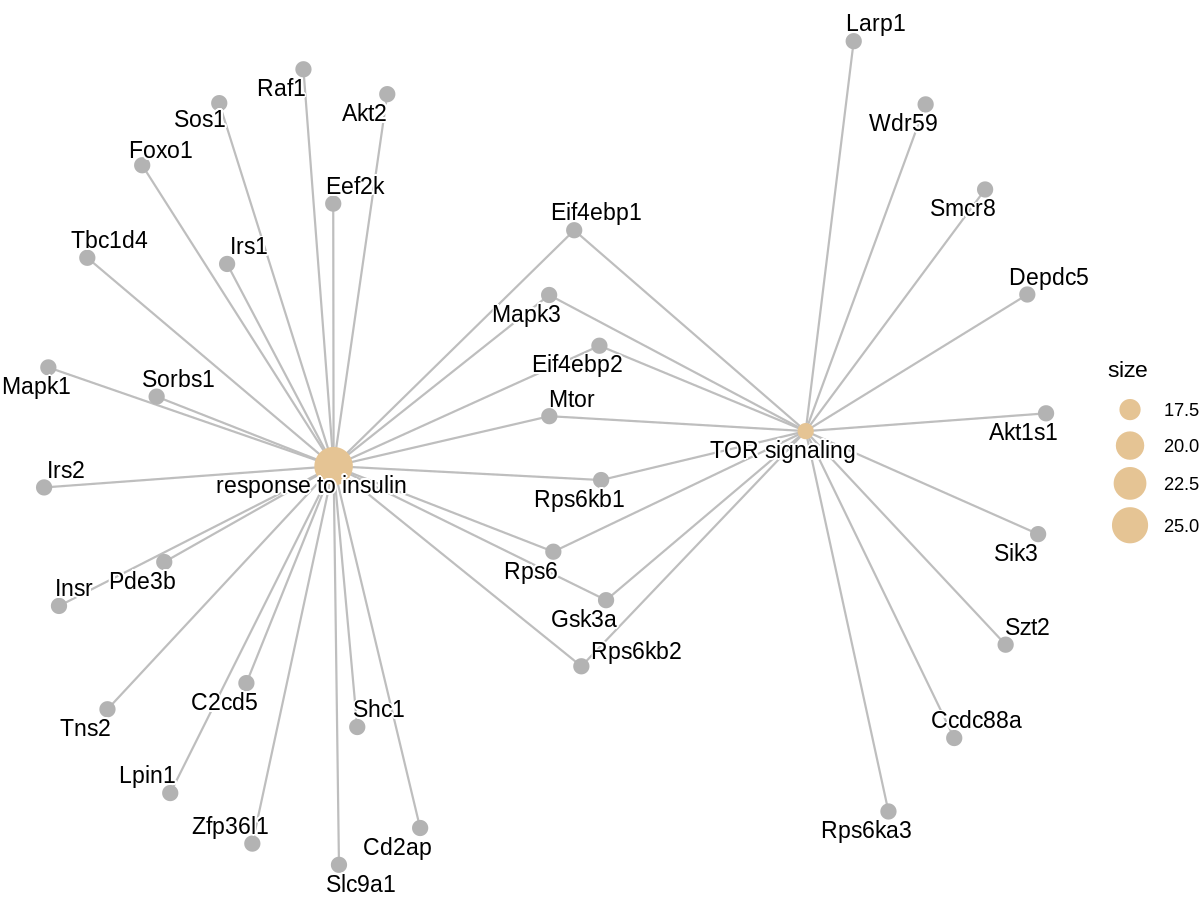

In [62]:
egox <- setReadable(ego, 'org.Mm.eg.db', 'ENTREZID')
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res=150)
cnetplot(x=egox,
         showCategory=c("response to insulin","TOR signaling"),
         #circular=T,
         color.params=list(edge = T),
         cex.params=list(category_label=0.8, gene_label=0.8))

GO-ORA results visualization with emap plot...

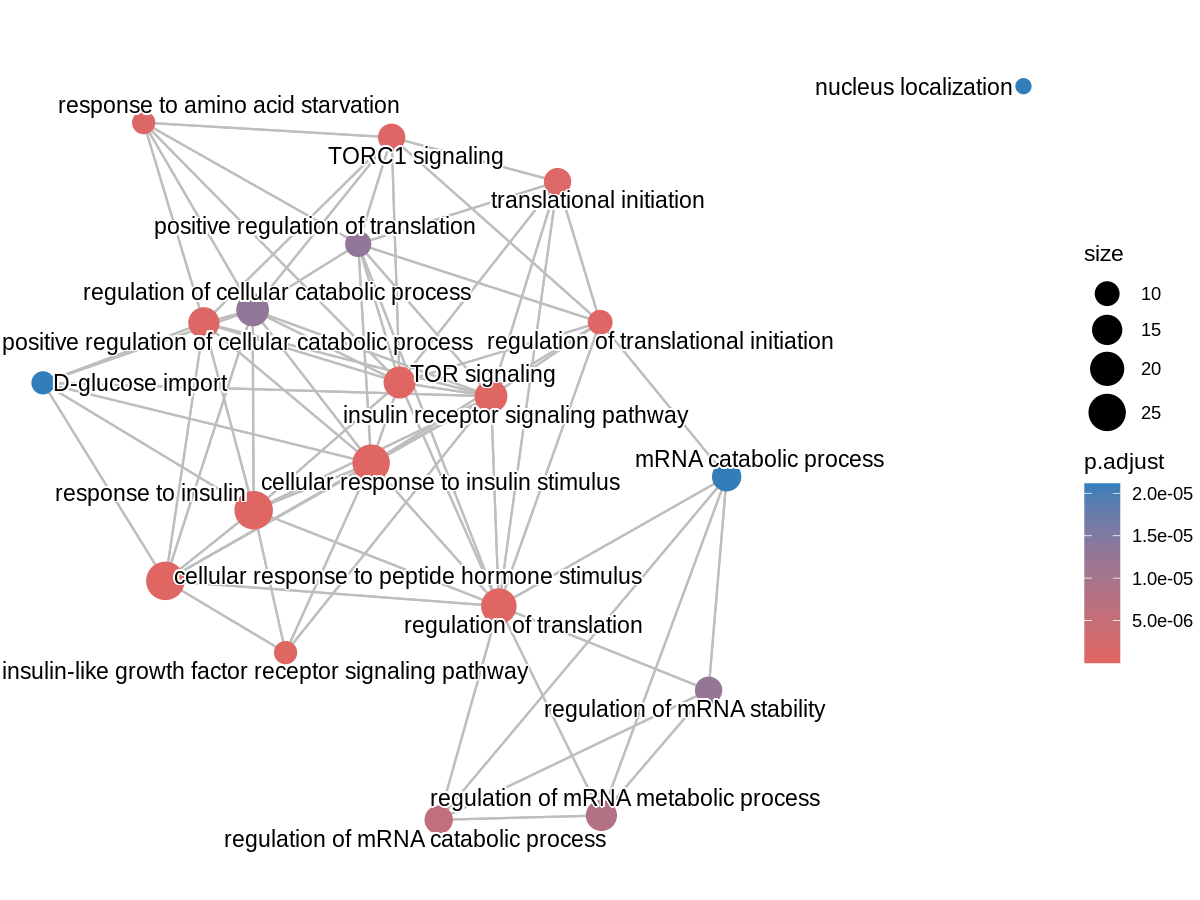

In [63]:
egox2 <- enrichplot::pairwise_termsim(egox)
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res=150)
emapplot(x=egox2, showCategory=20)

GO-ORA results visualization with upset plot...

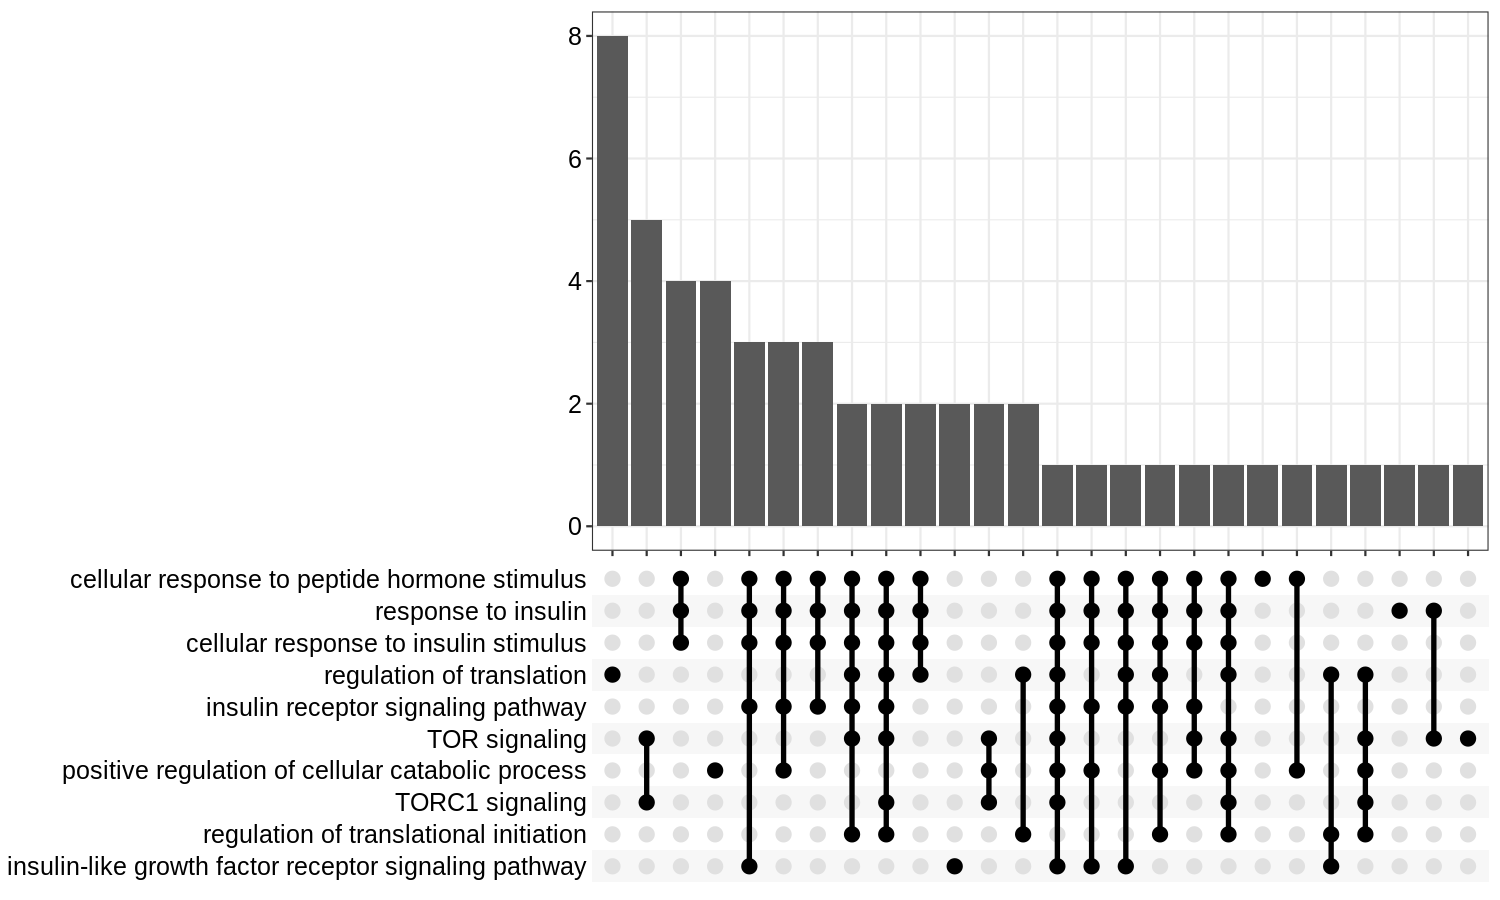

In [64]:
options(repr.plot.width=10, repr.plot.height=6, repr.plot.res=150)
enrichplot::upsetplot(ego)

# **Reactome-based overrepresentation**
In order to perform Reactome-based overrepresentation analysis ("Reactome-analysis" or "Reactome-ORA") in R...

In [ ]:
# Warning: Installation of the package takes ca. 4 minutes in Colab!
setRepositories(ind=1:5)
install.packages("ReactomePA")
library("ReactomePA")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gridExtra’, ‘RcppArmadillo’, ‘viridis’, ‘tidygraph’, ‘graphlayouts’, ‘graph’, ‘ggraph’, ‘reactome.db’, ‘graphite’


ReactomePA v1.50.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for
reactome pathway analysis and visualization. Molecular BioSystems.
2016, 12(2):477-479



The enrichPathway() function is used to make all settings (organism, cutoffs, sizes of terms) and pass our input set of candidate genes.

In [ ]:
reactome.res <- enrichPathway(entrez.ids,
                              organism="mouse",
                              pvalueCutoff=1.0,
                              pAdjustMethod = "BH",
                              qvalueCutoff = 0.01,
                              minGSSize = 10,
                              maxGSSize = 707)

The results are already available as a sorted table. We can directly index the results table for the top 10 pathways and the most informative columns.

In [ ]:
reactome.res2 <- reactome.res[1:10,c("Description", "p.adjust")]
reactome.res2

,Description,p.adjust
,<chr>,<dbl>
R-MMU-74749,Signal attenuation,2.403349e-08
R-MMU-165159,MTOR signalling,1.826387e-07
R-MMU-166208,mTORC1-mediated signalling,4.468296e-07
R-MMU-74751,Insulin receptor signalling cascade,8.242280e-07
R-MMU-74752,Signaling by Insulin receptor,5.643549e-05
R-MMU-194315,Signaling by Rho GTPases,3.089910e-04
R-MMU-1257604,PIP3 activates AKT signaling,3.728961e-04
R-MMU-9716542,"Signaling by Rho GTPases, Miro GTPases and RHOBTB3",3.728961e-04
R-MMU-187037,Signaling by NTRK1 (TRKA),5.859172e-04


Results visualization:

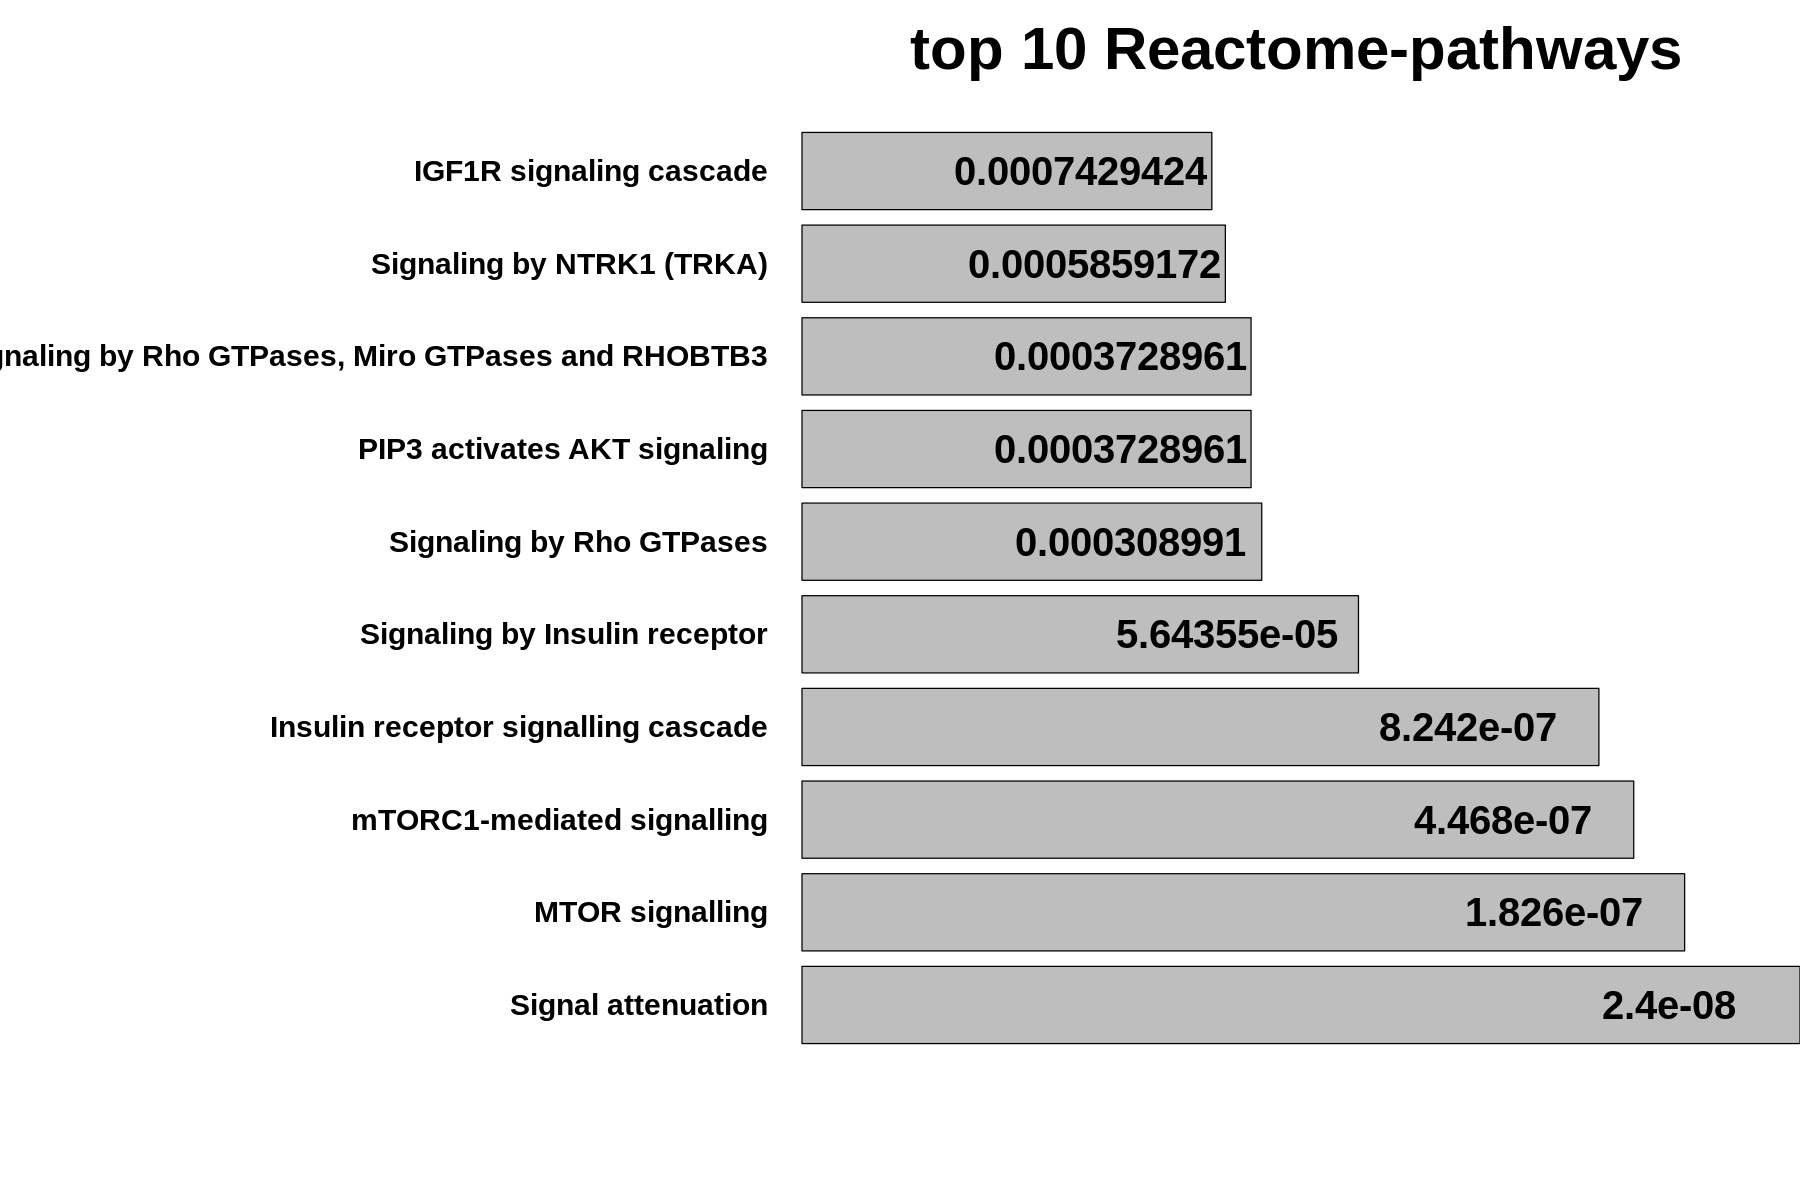

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
par(mar=c(5, 33, 4, 0))
p <- barplot(-log10(reactome.res2[,"p.adjust"]), names.arg=reactome.res2[,"Description"], horiz=T, axes=F, las=1, cex.names=1.5, cex.main=3, font=2, main="top 10 Reactome-pathways")
text(x=-log10(reactome.res2[,"p.adjust"]) - 1, y=p, labels=round(reactome.res2[,"p.adjust"],10), font=2, cex=2)